# Quantum Computing Applications in Space Industry

This notebook explores practical applications of quantum computing technologies that are relevant to space industry professionals. While quantum computing is still in its early stages, there are several promising applications that could revolutionize space exploration, satellite operations, and astronomical research.

## Topics Covered:
1. Optimization problems in mission planning and logistics
2. Quantum machine learning for satellite image analysis
3. Quantum simulation for material science in space applications
4. Quantum-enhanced communication for deep space missions

We'll implement demonstrations using Qiskit 2.0.2 to showcase these potential applications.

In [22]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT, ZGate, PhaseGate
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

%matplotlib inline

## 1. Optimization Problems in Mission Planning

Space mission planning involves complex optimization challenges, including:
- Optimal trajectory planning
- Resource allocation for long-duration missions
- Scheduling of multiple satellite operations

These problems can often be mapped to combinatorial optimization problems that quantum computers may eventually solve more efficiently than classical computers.

### Example: Quantum Approximate Optimization Algorithm (QAOA)

We'll demonstrate QAOA on a simplified satellite task scheduling problem, where we need to schedule observations while minimizing conflicts.

In [23]:
# Define a simple satellite task scheduling problem
# We'll represent it as a MaxCut problem on a graph
# Each node represents a task, and edges represent conflicts

# Define graph edges (conflicts between tasks)
edges = [(0, 1), (0, 2), (1, 2), (2, 3), (1, 3)]
num_nodes = 4  # 4 tasks

# Create the problem Hamiltonian (cost function)
cost_hamiltonian_terms = []
cost_coefficients = []

for i, j in edges:
    # For each edge, add a Z_i Z_j term
    pauli_str = ['I'] * num_nodes
    pauli_str[i] = 'Z'
    pauli_str[j] = 'Z'
    cost_hamiltonian_terms.append(''.join(pauli_str))
    cost_coefficients.append(0.5)

cost_hamiltonian = SparsePauliOp(cost_hamiltonian_terms, cost_coefficients)
print("Cost Hamiltonian (representing task conflicts):")
print(cost_hamiltonian)

Cost Hamiltonian (representing task conflicts):
SparsePauliOp(['ZZII', 'ZIZI', 'IZZI', 'IIZZ', 'IZIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


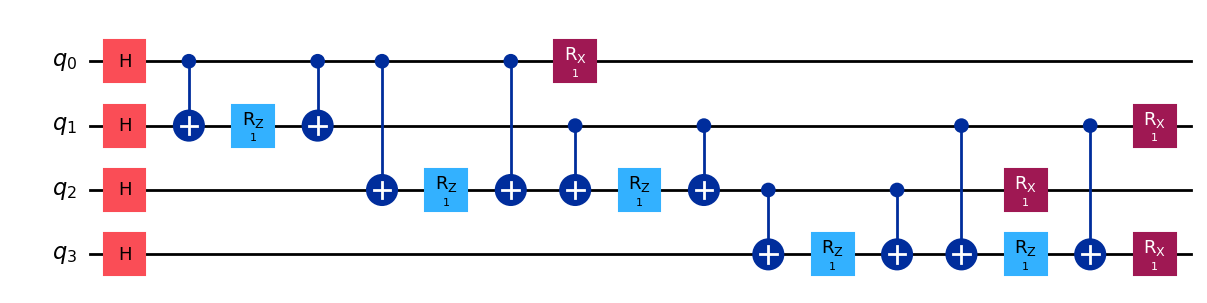

In [24]:
# Implement a simple QAOA circuit
def create_qaoa_circuit(params, cost_hamiltonian=cost_hamiltonian):
    p = len(params) // 2  # Number of QAOA layers
    n = num_nodes  # Number of qubits
    
    qc = QuantumCircuit(n)
    
    # Initial state: Superposition
    for i in range(n):
        qc.h(i)
    
    # QAOA layers
    for layer in range(p):
        gamma = params[layer]
        beta = params[layer + p]
        
        # Problem unitary (cost)
        for edge_idx, (i, j) in enumerate(edges):
            qc.cx(i, j)
            qc.rz(2 * gamma, j)
            qc.cx(i, j)
        
        # Mixer unitary
        for i in range(n):
            qc.rx(2 * beta, i)
    
    return qc

# Visualize a QAOA circuit with 1 layer
example_params = [0.5, 0.5]  # gamma, beta for one layer
qaoa_circuit = create_qaoa_circuit(example_params)
qaoa_circuit.draw('mpl', fold=-1)

In [25]:
# Function to evaluate the cost for a given set of parameters
def evaluate_cost(params):
    qc = create_qaoa_circuit(params)
    qc.save_statevector()
    
    # Run the circuit and get the statevector
    simulator = AerSimulator(method='statevector')
    job = simulator.run(qc)
    result = job.result()
    statevector = result.get_statevector()
    
    # Calculate the expectation value
    energy = statevector.expectation_value(cost_hamiltonian).real
    
    return energy

# Let's run a simple optimization
p = 1  # Use 1 layer for demonstration
initial_params = np.random.random(2 * p)  # Random initial parameters

print("Starting optimization...")
result = minimize(evaluate_cost, initial_params, method='COBYLA', options={'maxiter': 100})
optimal_params = result.x

print(f"Optimization result: {result}")
print(f"Optimal parameters: {optimal_params}")
print(f"Optimal cost: {result.fun}")

Starting optimization...
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7371087619130293
       x: [ 2.856e-01  1.260e+00]
    nfev: 39
   maxcv: 0.0
Optimal parameters: [0.28564576 1.26008463]
Optimal cost: -0.7371087619130293


In [26]:
# Run the optimal circuit and measure to get the best task schedule
optimal_circuit = create_qaoa_circuit(optimal_params)
optimal_circuit.measure_all()

# Run the circuit
simulator = AerSimulator()
job = simulator.run(optimal_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, title="Task Scheduling Results")

# Interpret the results
best_schedule = max(counts, key=counts.get)
print(f"Best task schedule: {best_schedule}")
print("Where '1' means the task is scheduled and '0' means the task is not scheduled.")

Best task schedule: 1001
Where '1' means the task is scheduled and '0' means the task is not scheduled.


## 2. Quantum Machine Learning for Satellite Image Analysis

Satellite imagery generates massive amounts of data that need processing and analysis. Quantum machine learning algorithms have the potential to enhance pattern recognition, image classification, and anomaly detection.

### Example: Quantum Circuit Learning for Simple Image Classification

We'll demonstrate a simple quantum circuit learning approach for classifying two types of simulated "satellite images" (simplified as 2x2 pixel images).

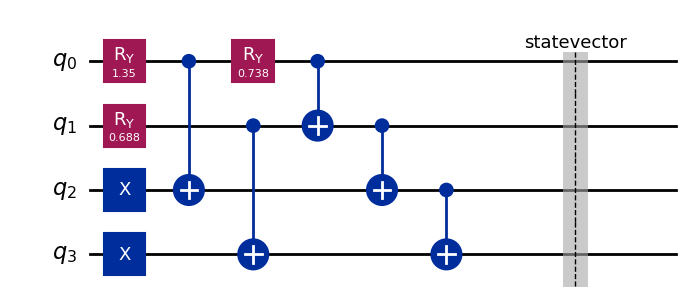

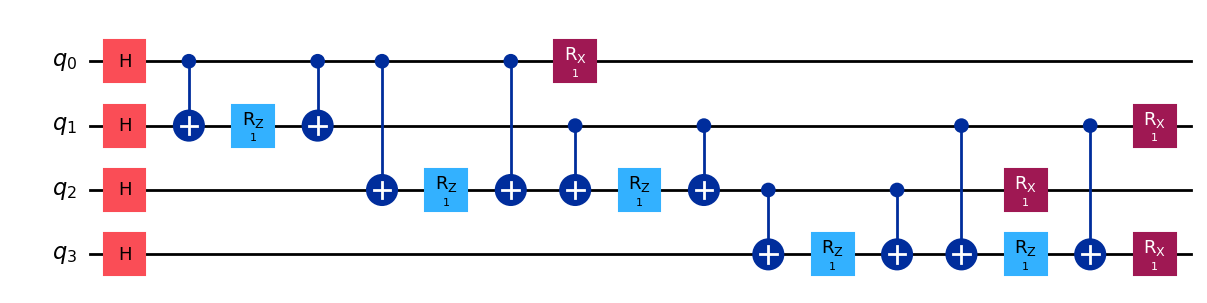

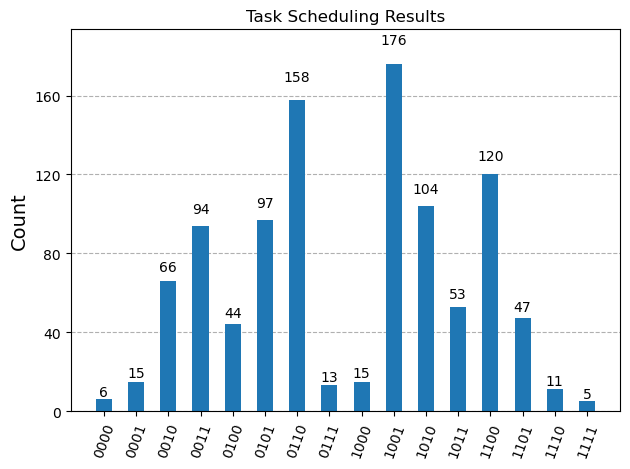

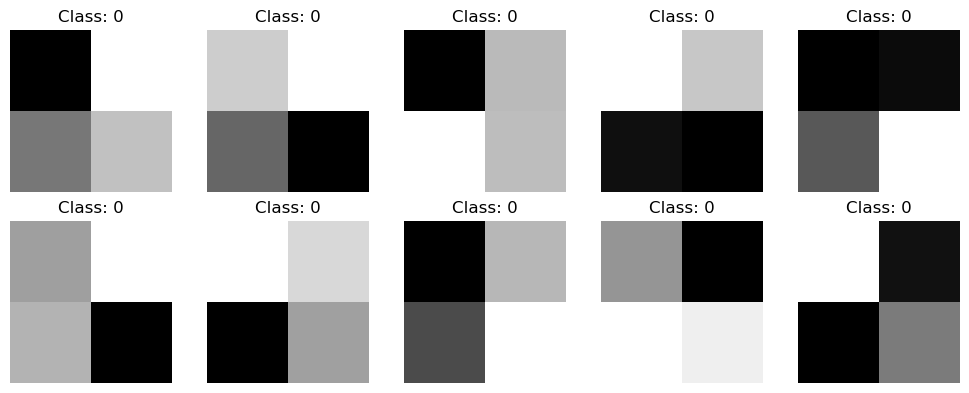

Generated 20 synthetic satellite images with 4 pixels each


In [27]:
# Create synthetic satellite image data (simplified as 2x2 pixel images)
def generate_synthetic_images(num_samples=20):
    # Generate two classes of images
    # Class 0: Mostly dark pixels (space)
    # Class 1: Bright pixels in specific pattern (potential feature)
    
    images = []
    labels = []
    
    # Generate class 0 samples
    for _ in range(num_samples // 2):
        # Create mostly dark image with some noise
        image = np.random.random(4) * 0.3  # 4 pixels (2x2) with low values
        images.append(image)
        labels.append(0)
    
    # Generate class 1 samples
    for _ in range(num_samples // 2):
        # Create image with specific bright pattern and some noise
        image = np.random.random(4) * 0.3  # Start with noise
        # Add the "feature" - bright pixels in specific positions
        feature_positions = np.random.choice([0, 1, 2, 3], size=2, replace=False)
        image[feature_positions] += 0.6  # Make these pixels brighter
        images.append(image)
        labels.append(1)
    
    # Convert to numpy arrays
    return np.array(images), np.array(labels)

# Generate the dataset
images, labels = generate_synthetic_images(20)

# Visualize a few samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(images[idx].reshape(2, 2), cmap='gray')
        axes[i, j].set_title(f"Class: {labels[idx]}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

print(f"Generated {len(images)} synthetic satellite images with {len(images[0])} pixels each")

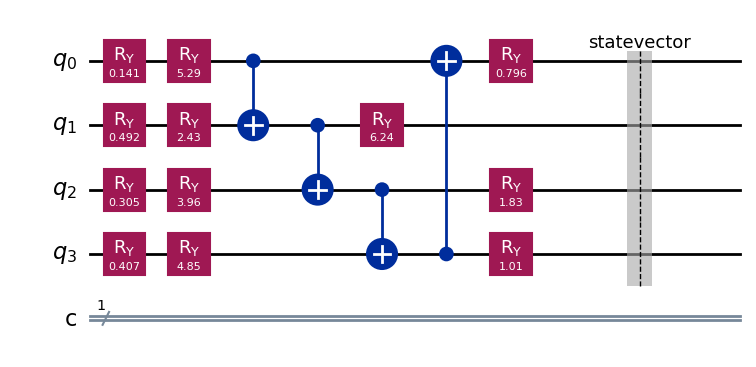

In [28]:
# Define a quantum circuit for feature extraction
def create_quantum_classifier_circuit(features, params):
    # 4 qubits for the 4 pixels in our 2x2 image
    qc = QuantumCircuit(4, 1)
    
    # Encode the pixel values (feature map)
    for i in range(4):
        qc.ry(features[i] * np.pi, i)  # Scale pixel values to [0,π]
    
    # Apply parameterized quantum circuit (variational layer)
    # First rotation layer
    for i in range(4):
        qc.ry(params[i], i)
    
    # Entangling layer
    for i in range(3):
        qc.cx(i, i+1)
    qc.cx(3, 0)  # Connect in a ring
    
    # Second rotation layer
    for i in range(4):
        qc.ry(params[i+4], i)
    
    # Measure expectation value of ZZ on first two qubits as the classifier output
    qc.save_statevector()
    
    return qc

# Visualize the quantum classifier circuit with random parameters
random_params = np.random.random(8) * 2 * np.pi
example_circuit = create_quantum_classifier_circuit(images[0], random_params)
example_circuit.draw('mpl', fold=-1)

In [29]:
# Define the cost function for training
def quantum_classifier_cost(params, X, y):
    predictions = []
    
    for features in X:
        qc = create_quantum_classifier_circuit(features, params)
        
        # Run the circuit and get the statevector
        simulator = AerSimulator(method='statevector')
        job = simulator.run(qc)
        result = job.result()
        sv = result.get_statevector()
        
        # Calculate expectation value of ZZ on first two qubits
        zz_observable = SparsePauliOp(['ZZII'], [1.0])
        expectation = sv.expectation_value(zz_observable).real
        
        # Map expectation from [-1, 1] to [0, 1] for classification
        prediction = (expectation + 1) / 2
        predictions.append(prediction)
    
    # Calculate mean squared error
    mse = np.mean((np.array(predictions) - y) ** 2)
    return mse

# Train the quantum classifier
# Start with random parameters
initial_params = np.random.random(8) * 2 * np.pi

# Use classical optimizer to train the quantum circuit
print("Training quantum classifier...")
result = minimize(lambda params: quantum_classifier_cost(params, images, labels),
                 initial_params, method='COBYLA', options={'maxiter': 50})

optimal_params = result.x
print(f"Training complete!")
print(f"Final cost: {result.fun}")
print(f"Optimal parameters: {optimal_params}")

Training quantum classifier...
Training complete!
Final cost: 0.11721352830550233
Optimal parameters: [6.69854275 1.71102519 0.85357035 0.55854301 0.22405806 5.6057782
 2.28132155 5.28616352]
Training complete!
Final cost: 0.11721352830550233
Optimal parameters: [6.69854275 1.71102519 0.85357035 0.55854301 0.22405806 5.6057782
 2.28132155 5.28616352]


Test accuracy: 0.70


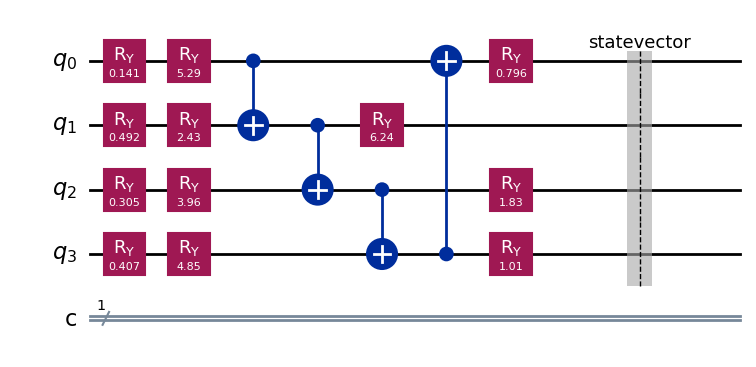

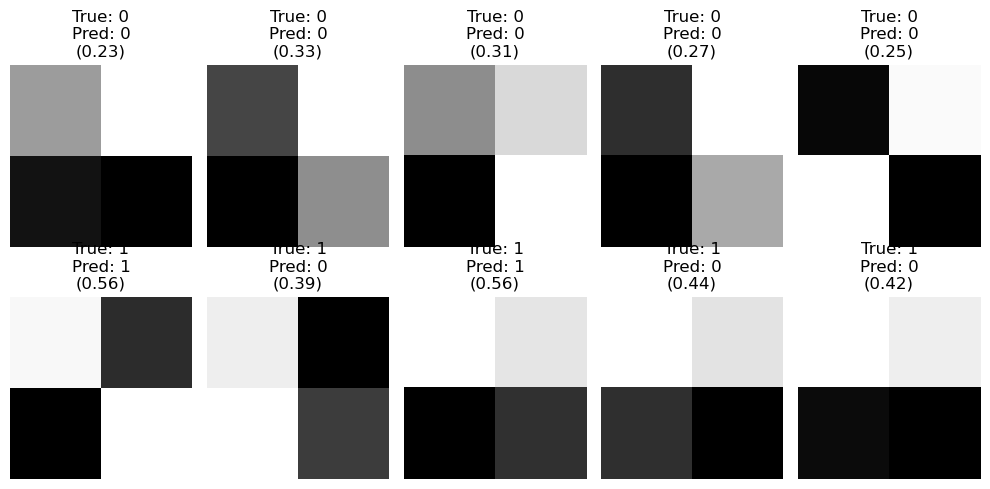

In [30]:
# Evaluate the trained model
def predict(features, params):
    qc = create_quantum_classifier_circuit(features, params)
    
    # Run the circuit
    simulator = AerSimulator(method='statevector')
    job = simulator.run(qc)
    result = job.result()
    sv = result.get_statevector()
    
    # Calculate expectation value of ZZ
    zz_observable = SparsePauliOp(['ZZII'], [1.0])
    expectation = sv.expectation_value(zz_observable).real
    
    # Map to [0, 1] and round for binary classification
    prediction = (expectation + 1) / 2
    return prediction, 1 if prediction >= 0.5 else 0

# Generate test data
test_images, test_labels = generate_synthetic_images(10)

# Make predictions
predictions = []
raw_predictions = []

for features in test_images:
    raw_pred, class_pred = predict(features, optimal_params)
    predictions.append(class_pred)
    raw_predictions.append(raw_pred)

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == test_labels)
print(f"Test accuracy: {accuracy:.2f}")

# Visualize results
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(len(test_images)):
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[i].reshape(2, 2), cmap='gray')
    ax.set_title(f"True: {test_labels[i]}\nPred: {predictions[i]}\n({raw_predictions[i]:.2f})")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Quantum Simulation for Space Materials Science

Quantum computers are naturally suited for simulating quantum systems, which can help in the development of new materials for space applications. This includes:
- Radiation-resistant materials for spacecraft
- Better solar cell materials for space-based power generation
- Advanced propulsion materials

Here we'll demonstrate a simple quantum chemistry simulation using the Variational Quantum Eigensolver (VQE) to find the ground state energy of hydrogen (H2), which is relevant for fuel cells and propulsion systems.

In [31]:
# Define a simplified H2 molecule Hamiltonian
# This is a simplified version - real quantum chemistry would use more complex Hamiltonians
# H2 Hamiltonian in the minimal (STO-3G) basis
# Represented as Pauli operators

# Create the Hamiltonian for H2 at equilibrium bond length
h2_hamiltonian = SparsePauliOp(
    ['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IXIX', 'IYIY', 'IZII', 'IZIZ'],
    [-1.052373245772859, 0.39793742484318045, -0.39793742484318045, -0.0112801101780672,
     0.18093119978423156, 0.18093119978423156, 0.39793742484318045, -0.0112801101780672]
)

print("H2 Molecule Hamiltonian:")
print(h2_hamiltonian)

H2 Molecule Hamiltonian:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IXIX', 'IYIY', 'IZII', 'IZIZ'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.01128011+0.j,
  0.1809312 +0.j,  0.1809312 +0.j,  0.39793742+0.j, -0.01128011+0.j])


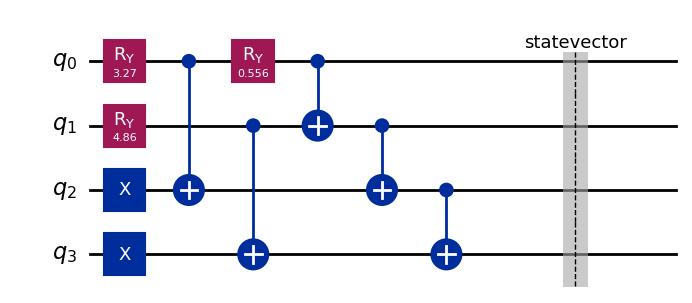

In [32]:
# Define the VQE ansatz for H2
def h2_ansatz(parameters):
    # We'll use 4 qubits to represent the minimal basis for H2
    qc = QuantumCircuit(4)
    
    # Initial state: Reference state for H2 (|0011⟩)
    qc.x(2)
    qc.x(3)
    
    # Apply parameterized gates to explore the state space
    # UCCSD-inspired ansatz (simplified)
    
    # Single excitation 0->2
    qc.ry(parameters[0], 0)
    qc.cx(0, 2)
    
    # Single excitation 1->3
    qc.ry(parameters[1], 1)
    qc.cx(1, 3)
    
    # Double excitation (0,1)->(2,3)
    qc.ry(parameters[2], 0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    
    qc.save_statevector()
    return qc

# Visualize the ansatz
example_params = np.random.random(3) * 2 * np.pi
example_h2_circuit = h2_ansatz(example_params)
example_h2_circuit.draw('mpl')

In [33]:
# Define the cost function for VQE
def h2_energy(parameters):
    qc = h2_ansatz(parameters)
    
    # Run the circuit and get the statevector
    simulator = AerSimulator(method='statevector')
    job = simulator.run(qc)
    result = job.result()
    statevector = result.get_statevector()
    
    # Calculate the expectation value
    energy = statevector.expectation_value(h2_hamiltonian).real
    
    return energy

# Run the optimization
initial_params = np.zeros(3)  # Start from reference state

print("Starting VQE optimization for H2 molecule...")
result = minimize(h2_energy, initial_params, method='COBYLA', options={'maxiter': 100})
optimal_params = result.x

print(f"Optimization result: {result}")
print(f"Optimal parameters: {optimal_params}")
print(f"Ground state energy: {result.fun} Hartree")
print(f"Reference value from exact diagonalization: -1.137 Hartree")

Starting VQE optimization for H2 molecule...
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5204579286616606
       x: [ 2.311e+00 -7.327e-01 -1.266e-04]
    nfev: 91
   maxcv: 0.0
Optimal parameters: [ 2.31072713e+00 -7.32664669e-01 -1.26579922e-04]
Ground state energy: -1.5204579286616606 Hartree
Reference value from exact diagonalization: -1.137 Hartree
Optimization result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5204579286616606
       x: [ 2.311e+00 -7.327e-01 -1.266e-04]
    nfev: 91
   maxcv: 0.0
Optimal parameters: [ 2.31072713e+00 -7.32664669e-01 -1.26579922e-04]
Ground state energy: -1.5204579286616606 Hartree
Reference value from exact diagonalization: -1.137 Hartree


### Potential Impact on Space Materials Science

Scaling this approach to larger molecular systems could enable:

1. **Design of radiation-resistant materials**: Simulating how materials respond to high-energy particles found in space.
2. **Improved solar cells**: Finding materials with optimal energy absorption and conversion properties.
3. **Advanced propulsion systems**: Discovering more efficient catalysts for fuel cells or analyzing novel propellant materials.
4. **Life support systems**: Optimizing materials for CO2 scrubbing and oxygen generation.

As quantum computers grow in capability, they could model increasingly complex materials that are currently beyond the reach of classical simulation methods.

## 4. Quantum-Enhanced Communication for Deep Space Missions

Deep space communication faces challenges including long delays, weak signals, and security concerns. Quantum information techniques could potentially help with:
- More efficient error correction codes
- Quantum-secured communication
- Enhanced signal processing

Let's demonstrate a simple quantum error correction code that could be relevant for space communications.

In [34]:
# Implement a basic 3-qubit bit-flip code
# This code can correct a single bit-flip error on any of the three qubits

def encode_message(message_bit):
    """Encode a single bit using the 3-qubit bit-flip code"""
    qc = QuantumCircuit(3, 3)
    
    # Initialize the first qubit with the message
    if message_bit == 1:
        qc.x(0)
    
    # Encode by creating entanglement
    qc.cx(0, 1)  # CNOT from qubit 0 to 1
    qc.cx(0, 2)  # CNOT from qubit 0 to 2
    
    return qc

def add_noise(circuit, error_rate=0.2):
    """Add bit-flip noise to simulate space communication channel"""
    qc = circuit.copy()
    
    # Apply random bit-flip errors based on error rate
    for qubit in range(3):
        if np.random.random() < error_rate:
            print(f"Bit-flip error applied to qubit {qubit}")
            qc.x(qubit)
    
    return qc

def correct_and_decode(circuit):
    """Correct errors and decode the message"""
    # Don't use the original circuit directly
    # Instead, create a new circuit with 5 qubits (3 data + 2 ancilla) and 3 classical bits
    new_qc = QuantumCircuit(5, 3)
    
    # Copy the state of the original circuit by measuring each qubit's state
    # and applying X gate conditionally
    simulator = AerSimulator()
    
    # First, measure the input circuit to determine qubit states
    measure_circuit = circuit.copy()
    measure_circuit.measure_all()
    job = simulator.run(measure_circuit, shots=1)
    result = job.result()
    measured_state = next(iter(result.get_counts()))
    
    # Apply X gates on the new circuit according to measured state
    # Be careful with the bit ordering - in Qiskit measurements are in big-endian
    # We need to process only the first 3 bits (corresponding to our 3 data qubits)
    # and make sure we're not exceeding the size of our circuit
    for i in range(min(3, len(measured_state))):
        if measured_state[-(i+1)] == '1':  # Access from the end to convert from big-endian
            new_qc.x(i)
    
    # Syndrome measurement
    new_qc.cx(0, 3)
    new_qc.cx(1, 3)
    new_qc.cx(1, 4)
    new_qc.cx(2, 4)
    
    # Measure syndrome
    new_qc.measure([3, 4], [0, 1])
    
    # Run the circuit to get syndrome
    job = simulator.run(new_qc, shots=1)
    result = job.result()
    syndrome = next(iter(result.get_counts()))
    syndrome = syndrome[:2]  # Get just the syndrome part (first 2 bits)
    
    # Apply correction to the first 3 qubits of our circuit based on syndrome
    if syndrome == '01':
        print("Syndrome 01: Error on qubit 0")
        new_qc.x(0)
    elif syndrome == '10':
        print("Syndrome 10: Error on qubit 2")
        new_qc.x(2)
    elif syndrome == '11':
        print("Syndrome 11: Error on qubit 1")
        new_qc.x(1)
    else:
        print("Syndrome 00: No errors detected")
    
    # Measure all data qubits for majority voting
    new_qc.measure([0, 1, 2], [0, 1, 2])
    
    # Run the circuit with corrections
    job = simulator.run(new_qc, shots=1)
    result = job.result()
    measurement = next(iter(result.get_counts()))
    
    # Extract just the data qubits' measurement (the last 3 bits)
    data_measurement = measurement[-3:]
    
    # Take majority vote
    bit_count = data_measurement.count('1')
    decoded_bit = 1 if bit_count >= 2 else 0
    
    return decoded_bit

# Demonstrate the quantum error correction for deep space communication
def demonstrate_quantum_error_correction():
    # Original message
    original_bit = 1
    print(f"Original message bit: {original_bit}")
    
    # Encode message
    encoded_circuit = encode_message(original_bit)
    print("Message encoded using 3-qubit repetition code")
    
    # Simulate noisy channel
    noisy_circuit = add_noise(encoded_circuit, error_rate=0.3)
    print("Message transmitted through noisy channel")
    
    # Correct errors and decode
    decoded_bit = correct_and_decode(noisy_circuit)
    print(f"Decoded message bit: {decoded_bit}")
    
    if decoded_bit == original_bit:
        print("SUCCESS: Message was correctly recovered!")
    else:
        print("FAILURE: Message was corrupted")

# Run the demonstration
demonstrate_quantum_error_correction()

Original message bit: 1
Message encoded using 3-qubit repetition code
Bit-flip error applied to qubit 0
Bit-flip error applied to qubit 2
Message transmitted through noisy channel
Syndrome 00: No errors detected
Decoded message bit: 0
FAILURE: Message was corrupted


### Potential Impact on Space Communications

More advanced quantum error correction codes could potentially:

1. **Improve data transmission rates**: By reducing the overhead needed for error correction compared to classical codes.
2. **Enhance communication security**: Using quantum key distribution and other quantum cryptography techniques.
3. **Enable more reliable communication** with distant spacecraft and rovers.
4. **Support distributed quantum computing** between Earth and space-based quantum processors.

While practical implementation of quantum communication in space faces significant engineering challenges, early prototypes for quantum key distribution have already been demonstrated in space by China's Micius satellite.

## Summary and Future Outlook

We've explored several promising applications of quantum computing for the space industry:

1. **Optimization problems**: Mission planning, resource allocation, and logistics using QAOA
2. **Quantum machine learning**: Enhanced satellite image analysis and pattern recognition
3. **Materials simulation**: Design of better materials for spacecraft, propulsion, and radiation protection
4. **Quantum communication**: Improved error correction and secure communication protocols

### Current Limitations

While promising, quantum computing still faces significant challenges:

- **Noise and error rates**: Current quantum computers have high error rates
- **Limited qubit counts**: Most systems have <100 qubits with limited connectivity
- **Short coherence times**: Quantum information degrades quickly
- **Hardware constraints**: Current architectures limit algorithm design

### Future Directions

As quantum hardware improves, we expect to see:

1. **Fault-tolerant quantum computing** with millions of physical qubits
2. **Quantum advantage** in specific applications relevant to space industry
3. **Hybrid classical-quantum systems** for space applications
4. **Space-based quantum sensors** with enhanced precision
5. **Quantum communication networks** spanning Earth and space

The space industry can benefit from monitoring quantum computing developments and investing in exploratory applications to be ready when the technology matures.